In [1]:
import seaborn as sns
import pandas as pd
import figures as fg

df_16 = pd.read_csv("../results/16jobs_results.csv")
df_4 = pd.read_csv("../results/4jobs_results.csv")
df_multinode = pd.read_csv("../results/multinode_res_39.out")

In [2]:
df_16

,experiment,repetition,runtime,max_mem
0,lustre,0,74.89,1942844
1,lustre,0,75.42,1942156
2,mem_all,0,143.03,1961564
3,mem_final,0,184.31,1960364
4,lustre,1,54.58,1939564
5,mem_final,1,184.28,1958296
6,lustre,1,54.51,1942788
7,mem_all,1,143.67,1959804
8,lustre,2,70.98,1942112
9,mem_final,2,186.34,1958784


# Experiment 1 - 16 parallel jobs & 39 617MB images incremented 10 times (total data generated: ~234GiB)

(0.0, 193.0525)

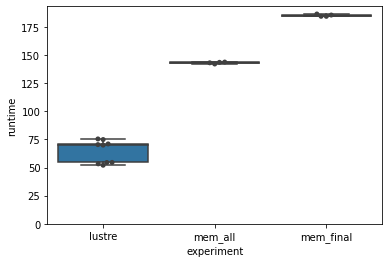

In [3]:
ax = sns.boxplot(x="experiment", y="runtime", data=df_16)
ax = sns.swarmplot(x="experiment", y="runtime", data=df_16, color=".25")
ax.set_ylim(bottom=0)

## Experiment 2 - 4 parallel jobs & 39 617MB images incremented 10 times (total data generated:~234GiB)

(0.0, 202.513)

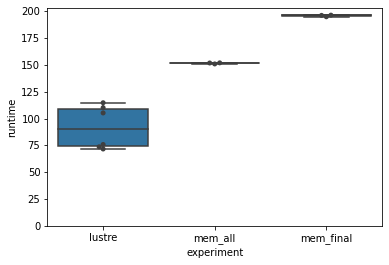

In [4]:
ax = sns.boxplot(x="experiment", y="runtime", data=df_4)
ax = sns.swarmplot(x="experiment", y="runtime", data=df_4, color=".25")
ax.set_ylim(bottom=0)

## Experiment 3 - 16 parallel jobs & Single node multidisk (all 6) & 39 617MB images incremented 10 times

In [5]:
multidisk = pd.read_csv("../results/multidisk_res.csv")
multidisk['runtime'] = multidisk['runtime'].apply(lambda x: float(x))
multidisk = multidisk[['experiment', 'repetition', 'runtime', 'disk_files', 'total_flush']]

In [6]:
multidisk

,experiment,repetition,runtime,disk_files,total_flush
0,mem_final,0,27.30,0,195
1,lustre,0,54.20,0,0
2,mem_all,0,61.45,0,196
3,lustre,1,78.88,0,0
4,mem_all,1,63.35,0,196
5,mem_final,1,61.39,0,187
6,lustre,2,47.89,0,0
7,mem_final,2,65.93,0,195
8,mem_all,2,26.69,0,196


(0.0, 81.48949999999999)

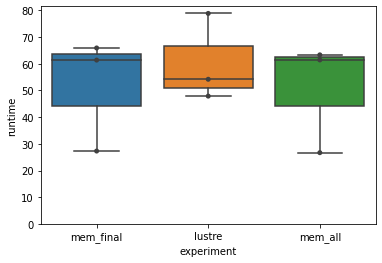

In [7]:
ax = sns.boxplot(x="experiment", y="runtime", data=multidisk)
ax = sns.swarmplot(x="experiment", y="runtime", data=multidisk, color=".25")
ax.set_ylim(bottom=0)

(0.0, 188.6742574578)

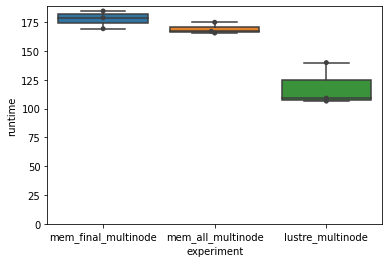

In [3]:
## experiment 4 multinode
df_multinode['runtime'] = df_multinode['runtime'].apply(lambda x: float(x))
df_multinode = df_multinode[['experiment', 'repetition', 'runtime', 'disk_files', 'total_flush']]
ax = sns.boxplot(x="experiment", y="runtime", data=df_multinode)
ax = sns.swarmplot(x="experiment", y="runtime", data=df_multinode, color=".25")
ax.set_ylim(bottom=0)

## Experiment 3 Gantt Charts

## Gantt Chart - Sea flush all files

In [8]:
fa_df = fg.load_df("../results/mem_all-2/benchmarks.out")
fg.bokeh_gantt(fa_df)

Loading BokehJS ...

## Gantt chart - Sea flush only final output (in-mem computing)

In [21]:
im_df = fg.load_df("../results/mem_final-1/benchmarks.out")
fg.bokeh_gantt(im_df)

Loading BokehJS ...

## Gantt chart - Write everything to Lustre

In [10]:
l_df = fg.load_df("../results/lustre-2/benchmarks.out")
fg.bokeh_gantt(l_df)

Loading BokehJS ...

In [9]:
fa_df = fg.load_df("../results/mem_all_multinode_2/benchmarks.out")
fg.bokeh_gantt(fa_df)

Loading BokehJS ...

In [7]:
im_df = fg.load_df("../results/mem_final_multinode_1/benchmarks.out")
fg.bokeh_gantt(im_df)

Loading BokehJS ...

In [6]:
l_df = fg.load_df("../results/lustre_multinode_2/benchmarks.out")
fg.bokeh_gantt(l_df)

Loading BokehJS ...

In [11]:
im_files = ["../results/mem_final-0/benchmarks.out",
            "../results/mem_final-1/benchmarks.out",
            "../results/mem_final-2/benchmarks.out"]
fa_files = ["../results/mem_all-0/benchmarks.out",
            "../results/mem_all-1/benchmarks.out",
            "../results/mem_all-2/benchmarks.out"]
lustre_files = ["../results/lustre-0/benchmarks.out",
                "../results/lustre-1/benchmarks.out",
                "../results/lustre-2/benchmarks.out"]

load_files = lambda x: [fg.load_df(f) for f in x]

im_dfs = load_files(im_files)
im_dfs = fg.add_rep_idx(im_dfs)

fa_dfs = load_files(fa_files)
fa_dfs = fg.add_rep_idx(fa_dfs)

lustre_dfs = load_files(lustre_files)
lustre_dfs = fg.add_rep_idx(lustre_dfs)
    
im_df = pd.concat(im_dfs, axis=0)
fa_df = pd.concat(fa_dfs, axis=0)
l_df = pd.concat(lustre_dfs, axis=0)
#print(im_df.head())
df = fg.group_actions(im_df, fa_df, l_df)



df.head()

,type,read,increment,write,read_lower,read_upper,inc_lower,inc_upper,write_lower,write_upper
0,Sea - In memory,560.737942,42.607720,64.389232,557.092674,564.383210,599.700394,606.990931,664.089626,671.380163
1,Sea - Flush all,561.389099,41.960864,64.754779,558.043134,564.735063,600.003998,606.695927,664.758777,671.450706
2,Lustre,624.543139,43.196362,155.773426,615.823875,633.262403,659.020238,676.458766,814.793664,832.232191


## Stacked Bar (read/increment/write) - All

In [12]:
fg.bokeh_stacked(df)

Loading BokehJS ...

In [18]:
df = pd.read_csv("../results/disk_benchmarks.out", header=None, names=["disk", "task", "speed", "metric"])
df[df["metric"] == "GB/s"]["speed"] = df[df["metric"] == "GB/s"]["speed"]*1024
df.loc[df["metric"] == "GB/s", "speed"] =

/home/valeriehayot/Documents/code/passthrough/.venv/lib64/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,disk,task,speed,metric
0,/dev/shm/seatmp/tmpfile,write,2.5,GB/s
1,/dev/shm/seatmp/tmpfile,cached,6.2,GB/s
2,/dev/shm/seatmp/tmpfile,read,6.6,GB/s
3,/disk0/vhs/seatmp/tmpfile,write,408.0,MB/s
4,/disk0/vhs/seatmp/tmpfile,cached,7.5,GB/s
5,/disk0/vhs/seatmp/tmpfile,read,504.0,MB/s
6,/disk1/vhs/seatmp/tmpfile,write,416.0,MB/s
7,/disk1/vhs/seatmp/tmpfile,cached,7.3,GB/s
8,/disk1/vhs/seatmp/tmpfile,read,507.0,MB/s
9,/disk2/vhs/seatmp/tmpfile,write,415.0,MB/s
